## Track fish in widefield fluorescence images
This notebook assumes a spark context is available

In [5]:
import numpy as np
from scipy.sparse import save_npz
import matplotlib.pyplot as plt
from glob import glob
from skimage.io import imread
import fishtrack.alignment as align
import fishtrack.filters as fish_filters
from pathlib import Path
import json
from functools import partial    
from os import mkdir
from os.path import exists
%matplotlib inline

In [6]:
def sparse_center_of_mass(image):
    from scipy.sparse import issparse
    from scipy.ndimage.measurements import center_of_mass
    from numpy import array, nan
    
    image_ = image.copy()
    result = (nan, nan)
    
    if issparse(image_):
        image_ = array(image_.todense())
    
    if image_.any():
        result = center_of_mass(image_)
    
    return result


def wipe_ims(pq):
    from numpy import zeros
    for iw in pq.images:
      iw.setImage(zeros((1,1))) #<- dummy 1x1 image
      iw.parent().close()

def save_params(params, fname):
    import json
    with open(fname,'w') as f:
        json.dump(params, f)
        
def mem_use():
    import os
    import psutil
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0]/2.**30  # memory use in GB...I think
    return memory_use

def pool_wrapper(function, data, num_cores, mode='map'):
    from multiprocessing import Pool
    with Pool(num_cores) as p:
        try:
            if mode == 'map':
                result = p.map(function, data)
            elif mode == 'starmap':
                result = p.starmap(function, data)
        except Exception as inst:
            print('There was a problem!')
            print(inst)
            return None
    return result

def get_mask_stats(masks):
    from scipy.ndimage.measurements import center_of_mass
    from numpy import array
    from scipy.sparse import issparse    
    
    mask_stats = {}
    masks_ = masks.copy()
    if issparse(masks_[0]):
        mask_stats['area'] = array([f.sum() for f in masks_])
        mask_stats['com'] = array([center_of_mass(array(f.todense())) for f in masks_])
    else:
        mask_stats['area'] = array([f.sum() for f in masks_])
        mask_stats['com'] = array([center_of_mass(f) for f in masks_])
    return mask_stats

In [67]:
base_paths = ['/groups/ahrens/ahrenslab/davis/data/epi/20170621/6dpf_cy221xcy221_f1_spon_1/',
             '/groups/ahrens/ahrenslab/davis/data/epi/20170621/6dpf_cy221xcy221_f1_spon_2/', 
             '/groups/ahrens/ahrenslab/davis/data/epi/20170621/6dpf_cy221xcy221_f2_spon_1/',
             '/groups/ahrens/ahrenslab/davis/data/epi/20170621/6dpf_cy221xcy221_f2_spon_2/',
             '/groups/ahrens/ahrenslab/davis/data/epi/20170621/6dpf_cy221xcy221_f3_spon_1/',
             '/groups/ahrens/ahrenslab/davis/data/epi/20170621/6dpf_cy221xcy221_f4_spon_1/',
             '/groups/ahrens/ahrenslab/davis/data/epi/20170621/6dpf_cy221xcy221_f4_spon_2/',
             '/groups/ahrens/ahrenslab/davis/data/epi/20170621/6dpf_cy221xcy221_f5_spon_1/',
             '/groups/ahrens/ahrenslab/davis/data/epi/20170621/6dpf_cy221xcy221_f5_spon_2/',
             '/groups/ahrens/ahrenslab/davis/data/epi/20170621/6dpf_cy221xcy221_f6_spon_1/',
             '/groups/ahrens/ahrenslab/davis/data/epi/20170909/7dpf_cy221xcy221_f1_1/',
             '/groups/ahrens/ahrenslab/davis/data/epi/20170909/7dpf_cy221xcy221_f2_1/',
             '/groups/ahrens/ahrenslab/davis/data/epi/20170909/7dpf_cy221xcy221_f3_1/',
             '/groups/ahrens/ahrenslab/davis/data/epi/20170909/7dpf_cy221xcy221_f4_1/',
              '/groups/ahrens/ahrenslab/davis/data/epi/20170909/7dpf_cy221xcy221_f5_no_agarose_1/',
             '/groups/ahrens/ahrenslab/davis/data/epi/20170909/7dpf_cy221xcy221_f6_1/',
             '/groups/ahrens/ahrenslab/davis/data/epi/20170909/7dpf_cy221xcy221_f7_1/',
             '/groups/ahrens/ahrenslab/davis/data/epi/20170909/7dpf_cy221xcy221_f8_1/'] 

In [68]:
im_fnames = [glob(d + 'Pos0/*.tif') for d in base_paths]
[imf.sort() for imf in im_fnames];

In [69]:
%%time

to_load = -1
plr_load = slice(0, None)

fnames = im_fnames[to_load][plr_load]
exp_name = str(Path(fnames[0]).parts[-3])
mask_dir = base_paths[to_load] + 'masks/'
mask_fnames = glob(mask_dir + 't*.npz')
mask_fnames.sort()
print('Current experiment: {0}'.format(exp_name))
param_fname = '{0}_params.json'.format(exp_name)

if Path(base_paths[to_load] + param_fname).exists():
    with open(base_paths[to_load] + param_fname, 'r') as f:
        params = json.load(f)
        print('Params loaded')
else:
    params = None
    print('Param file {0} not found'.format(param_fname))

ims = sc.parallelize(zip(range(len(fnames)), fnames)).mapValues(imread)
print('{0} {1}'.format(len(fnames), ims.values().first().shape))

Current experiment: 7dpf_cy221xcy221_f8_1
Param file 7dpf_cy221xcy221_f8_1_params.json not found
60000 (512, 512)
CPU times: user 96.5 ms, sys: 14.1 ms, total: 111 ms
Wall time: 997 ms


## Get fish masks

In [70]:
if params is None:
    params = {}
    # args for the fish mask finding
    params['fish_mask'] = {'sigma' : 2, 'disk_size' : 40, 'shrink_factors' : [.1,.1], 'min_sizes' : [100,100]}
    # set bbox to crop around the fish, formatted [x_start, y_start, x_end, y_end]
    params['fish_bbox'] = [-200, -100, 40, 100]
    # estimated size of the brain; used for fine registration
    params['brain_size'] = [80, 100]
    save_params(params, base_paths[to_load] + param_fname)  

fish_mask_wrapper = partial(fish_filters.get_fish_mask ,**params['fish_mask'])        

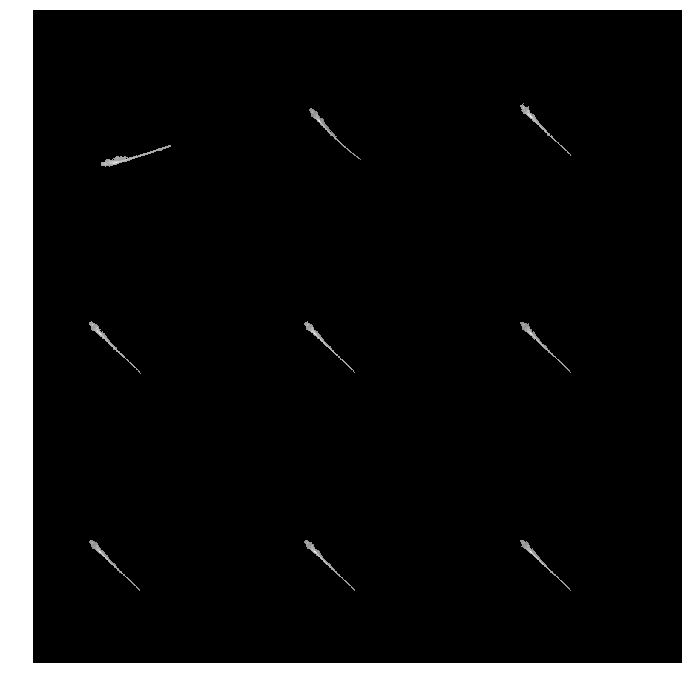

In [71]:
nr = 3
nc = 3
fig, axs= plt.subplots(nrows=nr, ncols=nc, figsize=(nr * 4,nc * 4))
times = np.linspace(0, (len(fnames) - 1), nr*nc).astype('int')

for ind, ax_ in enumerate(axs.ravel()):
    sample = imread(fnames[times[ind]])
    ax_.imshow((np.array(fish_mask_wrapper(sample).todense()) * sample), origin='lower', cmap='gray')
    ax_.axis('off')
plt.subplots_adjust(wspace=-.1,hspace=0)

## Generate fish masks if they weren't loaded

In [72]:
%%time
fish_masks = ims.mapValues(fish_mask_wrapper)
fish_masks.cache()
num_masks = fish_masks.count()

CPU times: user 33.9 ms, sys: 10.2 ms, total: 44.1 ms
Wall time: 3min 57s


## Save masks

In [73]:
%%time
overwrite_masks = True
save_masks = True
if not exists(mask_dir):
    save_masks = True
    mkdir(mask_dir)

if save_masks or overwrite_masks:
    print('saving fish masks in {0}'.format(mask_dir))
    mask_fnames = [mask_dir + 't{:09d}_mask.npy'.format(ind) for ind in range(num_masks)]
    mask_fnames_bc = sc.broadcast(mask_fnames)
    fish_masks.foreach(lambda kv: save_npz(mask_fnames_bc.value[kv[0]], kv[1]))

saving fish masks in /groups/ahrens/ahrenslab/davis/data/epi/20170909/7dpf_cy221xcy221_f8_1/masks/
CPU times: user 93.6 ms, sys: 23.9 ms, total: 117 ms
Wall time: 7min 11s


In [74]:
fish_masks_local = fish_masks.values().collect()

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:1301: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]


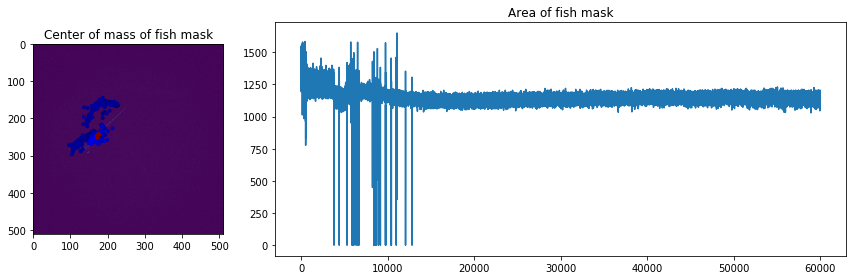

In [75]:
from matplotlib.cm import seismic
fig, axs = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios' : (1,3)}, figsize=(12,4))
axs[0].imshow(imread(fnames[-1]))
fish_mask_stats = get_mask_stats(fish_masks_local)
com = fish_mask_stats['com'].T[::-1]
colors = seismic(np.linspace(0,1,com.shape[1]))

axs[0].scatter(com[0], com[1], marker='.', color=colors)
axs[0].title.set_text('Center of mass of fish mask')
axs[1].title.set_text('Area of fish mask')
axs[1].plot(fish_mask_stats['area'])
plt.tight_layout()

## Localize the brain and the center of mass of the body

In [76]:
from scipy.ndimage.measurements import center_of_mass
from fishtrack.measurements import remotest_point

brain_centers = np.array(fish_masks.mapValues(remotest_point).values().collect())
body_centers = np.array(fish_masks.mapValues(sparse_center_of_mass).values().collect())

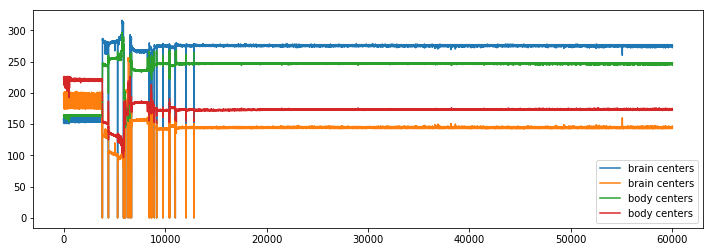

In [77]:
fig, axs = plt.subplots(figsize=(12,4))
axs.plot(brain_centers, label='brain centers')
axs.plot(body_centers, label='body centers')
axs.legend()

## Save body centers and brain centers to disk

In [78]:
np.savez(base_paths[to_load] + exp_name + '_position_data.npz', brain_centers=brain_centers, body_centers=body_centers)

## Get oriented masks and coarse transform parameters

In [79]:
%%time
#rotations = pool_wrapper(align.orient_tail, zip(fish_masks, brain_centers, body_centers), num_cores, mode='starmap')
tail_wrapper = lambda a,b,c: align.orient_tail(a.toarray(), b, c)
rotations = [tail_wrapper(*args) for args in  zip(fish_masks_local, brain_centers, body_centers)]

CPU times: user 22.8 s, sys: 179 ms, total: 22.9 s
Wall time: 22.9 s


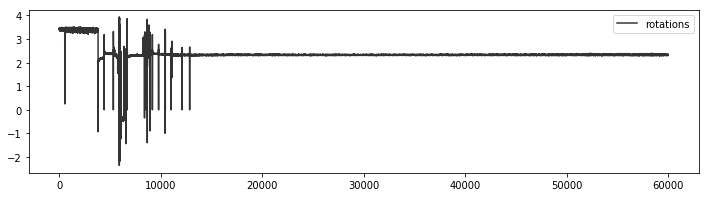

In [80]:
fig, axs = plt.subplots(nrows=1, figsize=(12,3), sharex=True, squeeze=False)
axs[0][0].plot(rotations,'k', alpha=.8, label='rotations')
axs[0][0].legend()

## Use transform parameters to generate cropped, masked fish image

In [81]:
%%time
# the crop window is relative to the estimated brain position
bbox = params['fish_bbox']
window_x = np.arange(bbox[0],bbox[2], dtype='int').reshape(-1,1)
window_y = np.arange(bbox[1],bbox[3], dtype='int')
crop_window = (window_y, window_x)

#oriented_ims = np.array(pool_wrapper(align.get_cropped_fish, zip(ims, rotations, brain_centers, crop_window), num_cores, mode='starmap'))
def orient_ims(kv):
    k = kv[0]
    v = kv[1]
    return k,align.get_cropped_fish(v, rotations[k], brain_centers[k], crop_window)
oriented_ims = ims.map(orient_ims)

CPU times: user 77 µs, sys: 5 µs, total: 82 µs
Wall time: 86.3 µs


## Do fine alignment on oriented fish images

In [82]:
%%time
t_ref = -1
static = oriented_ims.filter(lambda kv: kv[0] == range(len(fnames))[t_ref]).values().collect()[0]
static_bc = sc.broadcast(static)
brain_position = np.array([np.where(window_y==0)[0][0], np.where(window_x==0)[0][0]])
brain_size = params['brain_size']

def align_ims(kv):
    k,v = kv
    try:
        result = align.align_brains(static_bc.value, v, brain_position, brain_size)
    except ValueError:
        print('there was a problem with timepoint {0}'.format(k))
        result = []
    return (k,result)

aligned_ims_dist =  oriented_ims.map(align_ims).values().map(lambda v: v[0])
txs = oriented_ims.map(align_ims).values().map(lambda v: v[1]).collect()

CPU times: user 5.51 s, sys: 145 ms, total: 5.66 s
Wall time: 3min 22s


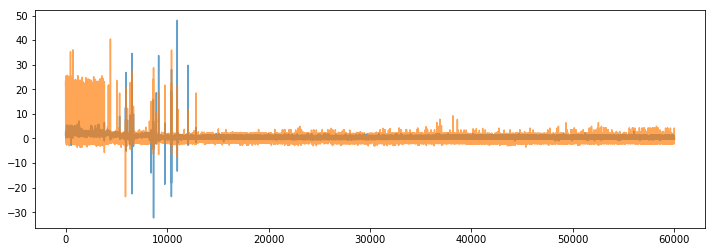

In [83]:
affines = np.array([tx.affine for tx in txs])
fig, axs = plt.subplots(figsize=(12,4))
axs.plot(affines[:,0,-1], alpha=.7)
axs.plot(affines[:,1,-1], alpha=.7)

In [84]:
bounds = aligned_ims_dist.map(lambda v: (v.min(), v.max())).collect()
mn, mx = np.array(bounds).min(), np.array(bounds).max()
from skimage.exposure import rescale_intensity
aligned_ims_dist = aligned_ims_dist.map(lambda v: rescale_intensity(v, in_range=(mn, mx), out_range='uint16').astype('uint16'))
aligned_ims = np.array(aligned_ims_dist.collect())

In [85]:
%%time
from skimage.io import imsave
imsave(base_paths[to_load] + exp_name + '_aligned.tif', aligned_ims)
np.save(base_paths[to_load] + 'regparams.npy', affines)

CPU times: user 18.9 s, sys: 5.72 s, total: 24.6 s
Wall time: 35.3 s


In [86]:
import pyqtgraph as pq
%gui qt
pq.image(aligned_ims)

In [ ]:
# this roi works for '/groups/ahrens/ahrenslab/davis/data/epi/20170621/6dpf_cy221xcy221_f2_spon_1/Pos0/'
from fishtrack.measurements import tail_angle
from scipy.ndimage.filters import median_filter
roi = (slice(0,None), slice(94,99), slice(190,194))
fs_im = 100
t = np.arange(oriented_ims.shape[0])[roi[0]] / fs_im
fig, axs = plt.subplots(nrows=2, figsize=(12,8))
ax_angle = axs[0]
ax_angle.plot(t, tail_angle(oriented_ims[roi[0]], (100,200), 90)[0], color='grey')
ax_angle.set_ylabel('Radians')
ts = oriented_ims[roi].mean((1,2))
floor_ = 1800
ceil_ = None
ax_fluo = ax_angle.twinx()
#ax_fluo.plot(t, ts.clip(floor_, ceil_), alpha = .4)
ax_fluo.plot(t, median_filter(ts, size=200).clip(floor_, ceil_), linewidth=2, color='k', alpha=.7)
ax_fluo.set_ylabel('Fluorescence Intensity [au]')
axs[0].legend([ax_angle.lines[-1], ax_fluo.lines[-1]], ['Tail angle','Smoothed fluorescence'], )

axs[0].set_xlabel('Time [s]')

from matplotlib.patches import Rectangle
axs[1].imshow(oriented_ims[roi[0]].mean(0), cmap='gray', origin='lower')
rect = Rectangle((roi[2].start, roi[1].start), roi[2].stop - roi[2].start, roi[1].stop - roi[1].start, fill=False, color='r')
axs[1].add_patch(rect)

# Test quality of tail orientation 

## Registration debugging 

In [ ]:
import numpy as np
from skimage.io import imread
from skimage import data_dir
from skimage.transform import rotate
from numpy import rad2deg
from dipy.align.imaffine import AffineRegistration
from dipy.align.transforms import RotationTransform2D 

affreg = AffineRegistration(verbosity=0)
rotation = RotationTransform2D()

static = imread(data_dir + "/phantom.png", as_grey=True)

rot_phi = .3
moving = rotate(static, rad2deg(rot_phi))
mg2w = np.array([[1,0,-moving.shape[0]//2],[0,1,-moving.shape[1]//2],[0,0,1]])
sg2w = mg2w
params0 = None
starting_affine = None
tx = affreg.optimize(static, moving, rotation, params0, static_grid2world=sg2w, moving_grid2world=mg2w, starting_affine=starting_affine)
titles = ['Static', 'Moving', 'Transformed Moving']

samp_g2w = np.eye(3)
samp_g2w[0,-1] = -200
samp_g2w[1,-1] = -200

fig, axs = plt.subplots(ncols = 3)
axs[0].imshow(static, origin='lower')
axs[1].imshow(moving, origin='lower')
axs[2].imshow(tx.transform(moving), origin='lower')
[axs[ind].title.set_text(val) for ind, val in enumerate(titles)]

print('True angle      : {0}'.format(rot_phi))
print('Estimated angle : {0}'.format(np.arccos(tx.affine[0,0])))

In [ ]:
from dipy.align.imaffine import AffineMap
from skimage.transform import AffineTransform
from skimage.transform import warp

In [ ]:
g2ws = np.eye(3)
g2ws[0,2] = -(static.shape[0] / 2)
g2ws[1,2] = -(static.shape[1] / 2)

g2wi = np.eye(3)
g2wi[0,2] = -(static.shape[0] / 2) - 100
g2wi[1,2] = -(static.shape[0] / 2)

affmap_r = AffineMap(np.eye(3))
affmap_r.codomain_shape = static.shape
affmap_r.domain_shape = static.shape

phi = np.pi
affmap_r.affine[:2,:2] = rotmat2d(phi)

dy, dx = 0,-100
affmap_r.affine[0,-1] = dy
affmap_r.affine[1,-1] = dx
rotated = affmap_r.transform(static, sampling_grid_shape=static.shape, sampling_grid2world=g2ws, image_grid2world=g2wi)

affmap_t = AffineMap(np.eye(3))
affmap_t.codomain_shape = static.shape
affmap_t.domain_shape = static.shape

dx, dy = 0,0
affmap_t.affine[0,-1] = dx
affmap_t.affine[1,-1] = dy

translated = affmap_t.transform(rotated, sampling_grid_shape=static.shape, sampling_grid2world = g2ws, image_grid2world=g2wi)
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(static + rotated, origin='lower')
axs[1].imshow(static + translated, origin='lower')

In [ ]:
plt.imshow(affine_wrapper(static, affmap.affine[:2,:2], np.array(static.shape) / 2, np.array(static.shape) / 2 + (0,0)), origin='lower')

In [ ]:
transform = affmap.affine[:2,:2]
c_in = np.array(static.shape) / 2
c_out = np.array(static.shape) / 2 + (100,100)
offset = c_in - c_out.dot(transform)
plt.imshow(affine_transform(static, transform.T, offset=offset), origin='lower')

In [ ]:
from skimage import data
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt

image = data.chelsea()[:,:,1]
def centered_rotation(image, rotation_center, new_center, phi):
    """
    Return an affine matrix for rotating an image around a center point
    """
    from numpy import array, matrix
    from skimage.transform import warp, AffineTransform
    origin_y, origin_x = rotation_center
    shift_y, shift_x = new_center
    tf_rotate = AffineTransform(rotation=phi)
    tf_shift = AffineTransform(translation=[-origin_x, -origin_y])
    tf_shift_inv = AffineTransform(translation=[shift_x, shift_y])
    params = (tf_shift + (tf_rotate + tf_shift_inv)).params
    tform = matrix(params).I
            
    return tform

shift = AffineTransform(translation = (100,100))
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(image, origin='lower')
from fishtrack.alignment import centered_rotation
tform = centered_rotation(image, np.array(image.shape) / 2, np.array(image.shape) / 2 + [10,100], np.pi/4)
axs[1].imshow(warp(image, AffineTransform(tform)), origin='lower')